In [2]:
# Step 1: Upload the CSV file
from google.colab import files
uploaded = files.upload()

# Step 2: Install the sentence-transformers library
!pip install -U sentence-transformers

# Step 3: Import necessary libraries
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
import torch

# Step 4: Load the CSV file into a DataFrame
# Replace 'your_file.csv' with the actual name of your uploaded file
df = pd.read_csv('/content/narratives_with_bleu_scores.csv')

# Step 5: Load the SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 6: Encode the sentences from the two columns
original_narratives = df['original_narrative_3'].tolist()
predicted_narratives = df['predicted_narrative'].tolist()

# Generate embeddings
original_embeddings = model.encode(original_narratives, convert_to_tensor=True)
predicted_embeddings = model.encode(predicted_narratives, convert_to_tensor=True)

# Step 7: Compute cosine similarity
similarity_scores = F.cosine_similarity(original_embeddings, predicted_embeddings, dim=1)

# Step 8: Append similarity scores to the DataFrame
df['similarity_score'] = similarity_scores.cpu().numpy()

# Step 9: Save the updated DataFrame to a new CSV file
df.to_csv('updated_file.csv', index=False)

# Optional: Download the updated CSV file
files.download('updated_file.csv')

Saving narratives_with_bleu_scores.csv to narratives_with_bleu_scores.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Step 1: Install required libraries for METEOR, BLEU, ROUGE, and BERTScore
!pip install nltk rouge-score bert-score

# Step 2: Import necessary libraries
import nltk
nltk.download('punkt_tab')
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
nltk.download('wordnet')  # Required for METEOR
nltk.download('omw-1.4')  # Optional for METEOR (multilingual support)

# Step 3: Initialize lists to store scores
meteor_scores = []
bleu_scores = []
rouge_l_scores = []
bert_f1_scores = []

# Step 4: Initialize ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Step 5: Compute similarity scores for each row
for orig, pred in zip(df['original_narrative_3'], df['predicted_narrative']):
    # Ensure inputs are strings and handle NaN or non-string values
    orig = str(orig) if pd.notnull(orig) else ""
    pred = str(pred) if pd.notnull(pred) else ""

    # Tokenize for METEOR and BLEU
    orig_tokens = nltk.word_tokenize(orig.lower())
    pred_tokens = nltk.word_tokenize(pred.lower())

    # METEOR score
    meteor = meteor_score([orig_tokens], pred_tokens)
    meteor_scores.append(meteor)

    # BLEU score (using 4-grams)
    bleu = sentence_bleu([orig_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_scores.append(bleu)

    # ROUGE-L score
    rouge_scores = rouge.score(orig, pred)
    rouge_l = rouge_scores['rougeL'].fmeasure
    rouge_l_scores.append(rouge_l)

    # BERTScore (computed later to optimize)
    # We'll batch BERTScore for efficiency

# Step 6: Compute BERTScore for all sentences at once
original_narratives = df['original_narrative_3'].fillna("").astype(str).tolist()
predicted_narratives = df['predicted_narrative'].fillna("").astype(str).tolist()
_, _, bert_f1 = bert_score(predicted_narratives, original_narratives, lang="en", rescale_with_baseline=True)
bert_f1_scores = bert_f1.numpy()

# Step 7: Append scores to DataFrame
df['meteor_score'] = meteor_scores
df['bleu_score'] = bleu_scores
df['rouge_l_score'] = rouge_l_scores
df['bert_f1_score'] = bert_f1_scores

# Step 8: Save the updated DataFrame to a new CSV file
df.to_csv('updated_file_with_all_scores.csv', index=False)

# Step 9: Download the updated CSV file
from google.colab import files
files.download('updated_file_with_all_scores.csv')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Summary Statistics of Similarity Metrics (Original Scale)


,bleu_score,similarity_score,meteor_score,rouge_l_score,bert_f1_score
count,1.686000e+03,1686.000000,1686.000000,1686.000000,1686.000000
mean,1.169746e-01,0.841114,0.377540,0.322964,0.401257
std,8.624850e-02,0.068658,0.078431,0.082898,0.111120
min,3.558432e-233,0.158897,0.018587,0.000000,-0.250350
25%,6.314924e-02,0.802930,0.324949,0.268041,0.326176
50%,1.121652e-01,0.851924,0.375280,0.317757,0.390862
75%,1.687965e-01,0.888438,0.428502,0.370818,0.470681
max,4.285964e-01,0.966005,0.662245,0.618557,0.741568


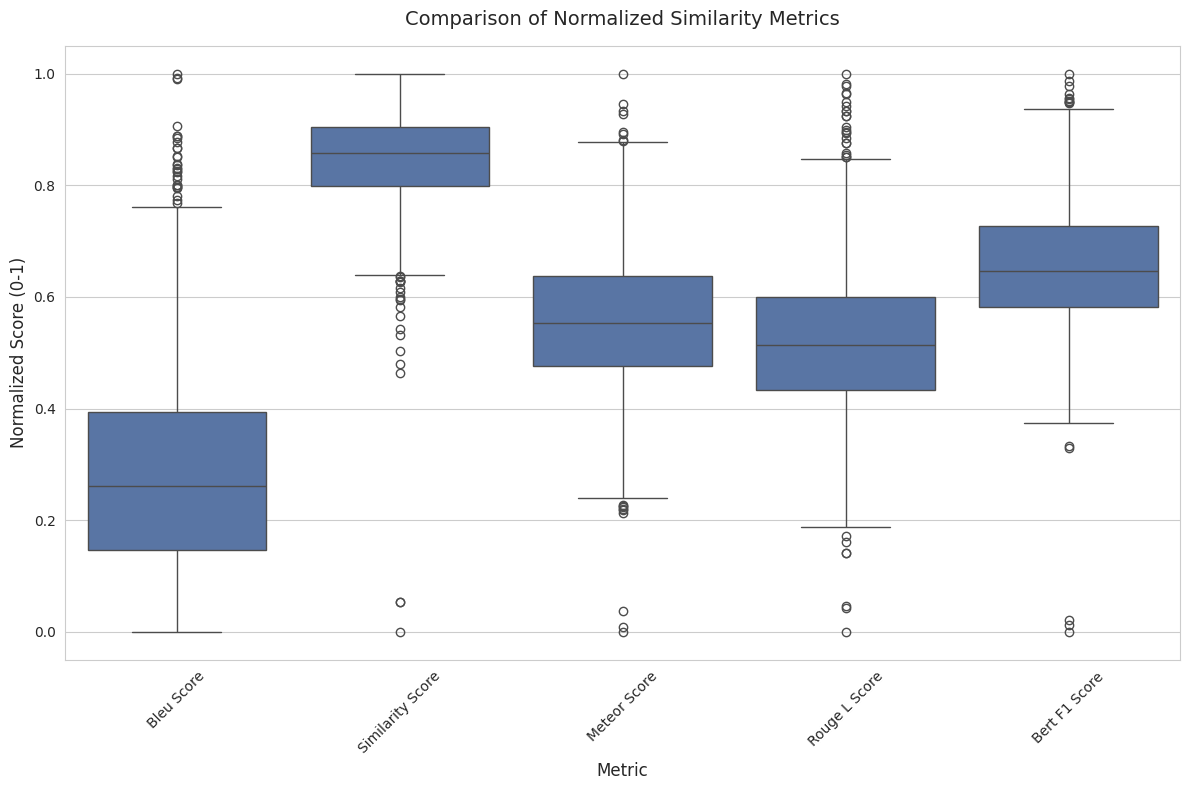


Conclusion:
The box plot compares the distributions of all similarity metrics after normalizing to a 0-1 scale. BLEU scores show a wider range and lower median compared to other metrics, indicating greater variability and generally lower values. Similarity, METEOR, ROUGE-L, and BERT F1 scores have higher medians and tighter distributions, suggesting more consistent performance. This visualization highlights that while semantic similarity metrics (e.g., similarity_score, BERT F1) are generally higher, exact word matching (BLEU) is less reliable for this model.


In [9]:
# Narrative Similarity Metrics Comparison in Google Colab
# This script generates a single box plot comparing all similarity metrics
# from the provided CSV file.

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Set Seaborn style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the CSV file
# Note: In Google Colab, upload 'updated_file_with_all_scores.csv' using the Files tab
# on the left sidebar, or mount Google Drive and provide the path
try:
    df = pd.read_csv('updated_file_with_all_scores.csv')
except FileNotFoundError:
    print("Error: 'updated_file_with_all_scores.csv' not found.")
    print("Please upload the file to Colab:")
    print("1. Click the folder icon in the left sidebar")
    print("2. Click the upload button and select 'updated_file_with_all_scores.csv'")
    print("3. Rerun this cell")
    raise

# Extract damage level from input_text (optional, for context)
df['damage_level'] = df['input_text'].str.extract(r'Damage level: (\d)').astype(float)

# Clean data: ensure numeric columns and remove invalid rows
metric_columns = ['bleu_score', 'similarity_score', 'meteor_score', 'rouge_l_score', 'bert_f1_score']
for col in metric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=metric_columns + ['damage_level'])

# Normalize metrics to 0-1 scale for fair comparison
df_normalized = df[metric_columns].copy()
for col in metric_columns:
    df_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Reshape data for box plot
df_melted = df_normalized.melt(var_name='Metric', value_name='Normalized Score')
df_melted['Metric'] = df_melted['Metric'].str.replace('_', ' ').str.title()

# 1. Summary Statistics
print("Summary Statistics of Similarity Metrics (Original Scale)")
summary_stats = df[metric_columns].describe()
display(summary_stats)

# 2. Single Box Plot Comparing All Metrics
plt.figure(figsize=(12, 8))
sns.boxplot(x='Metric', y='Normalized Score', data=df_melted)
plt.title('Comparison of Normalized Similarity Metrics', fontsize=14, pad=15)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Normalized Score (0-1)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Conclusion
print("\nConclusion:")
print("The box plot compares the distributions of all similarity metrics after normalizing to a 0-1 scale. BLEU scores show a wider range and lower median compared to other metrics, indicating greater variability and generally lower values. Similarity, METEOR, ROUGE-L, and BERT F1 scores have higher medians and tighter distributions, suggesting more consistent performance. This visualization highlights that while semantic similarity metrics (e.g., similarity_score, BERT F1) are generally higher, exact word matching (BLEU) is less reliable for this model.")

Summary Statistics of Similarity Metrics


,bleu_score,similarity_score,meteor_score,rouge_l_score,bert_f1_score
count,1.686000e+03,1686.000000,1686.000000,1686.000000,1686.000000
mean,1.169746e-01,0.841114,0.377540,0.322964,0.401257
std,8.624850e-02,0.068658,0.078431,0.082898,0.111120
min,3.558432e-233,0.158897,0.018587,0.000000,-0.250350
25%,6.314924e-02,0.802930,0.324949,0.268041,0.326176
50%,1.121652e-01,0.851924,0.375280,0.317757,0.390862
75%,1.687965e-01,0.888438,0.428502,0.370818,0.470681
max,4.285964e-01,0.966005,0.662245,0.618557,0.741568


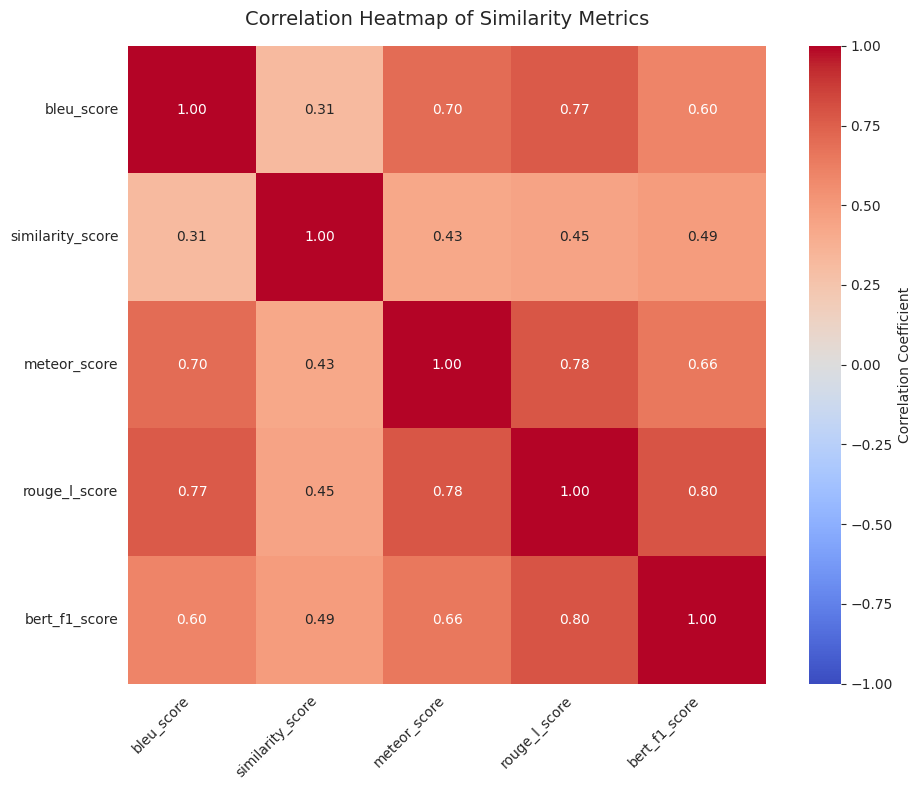

In [10]:
# Correlation Heatmap for Narrative Similarity Metrics in Google Colab
# This script generates a correlation heatmap for similarity metrics and discusses their relationships.

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Set Seaborn style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (10, 8)

# Load the CSV file
# Note: In Google Colab, upload 'updated_file_with_all_scores.csv' using the Files tab
# on the left sidebar, or mount Google Drive and provide the path
try:
    df = pd.read_csv('updated_file_with_all_scores.csv')
except FileNotFoundError:
    print("Error: 'updated_file_with_all_scores.csv' not found.")
    print("Please upload the file to Colab:")
    print("1. Click the folder icon in the left sidebar")
    print("2. Click the upload button and select 'updated_file_with_all_scores.csv'")
    print("3. Rerun this cell")
    raise

# Extract damage level from input_text (optional, for context)
df['damage_level'] = df['input_text'].str.extract(r'Damage level: (\d)').astype(float)

# Clean data: ensure numeric columns and remove invalid rows
metric_columns = ['bleu_score', 'similarity_score', 'meteor_score', 'rouge_l_score', 'bert_f1_score']
for col in metric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=metric_columns + ['damage_level'])

# 1. Summary Statistics
print("Summary Statistics of Similarity Metrics")
summary_stats = df[metric_columns].describe()
display(summary_stats)

# 2. Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[metric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            fmt='.2f', square=True, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Similarity Metrics', fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

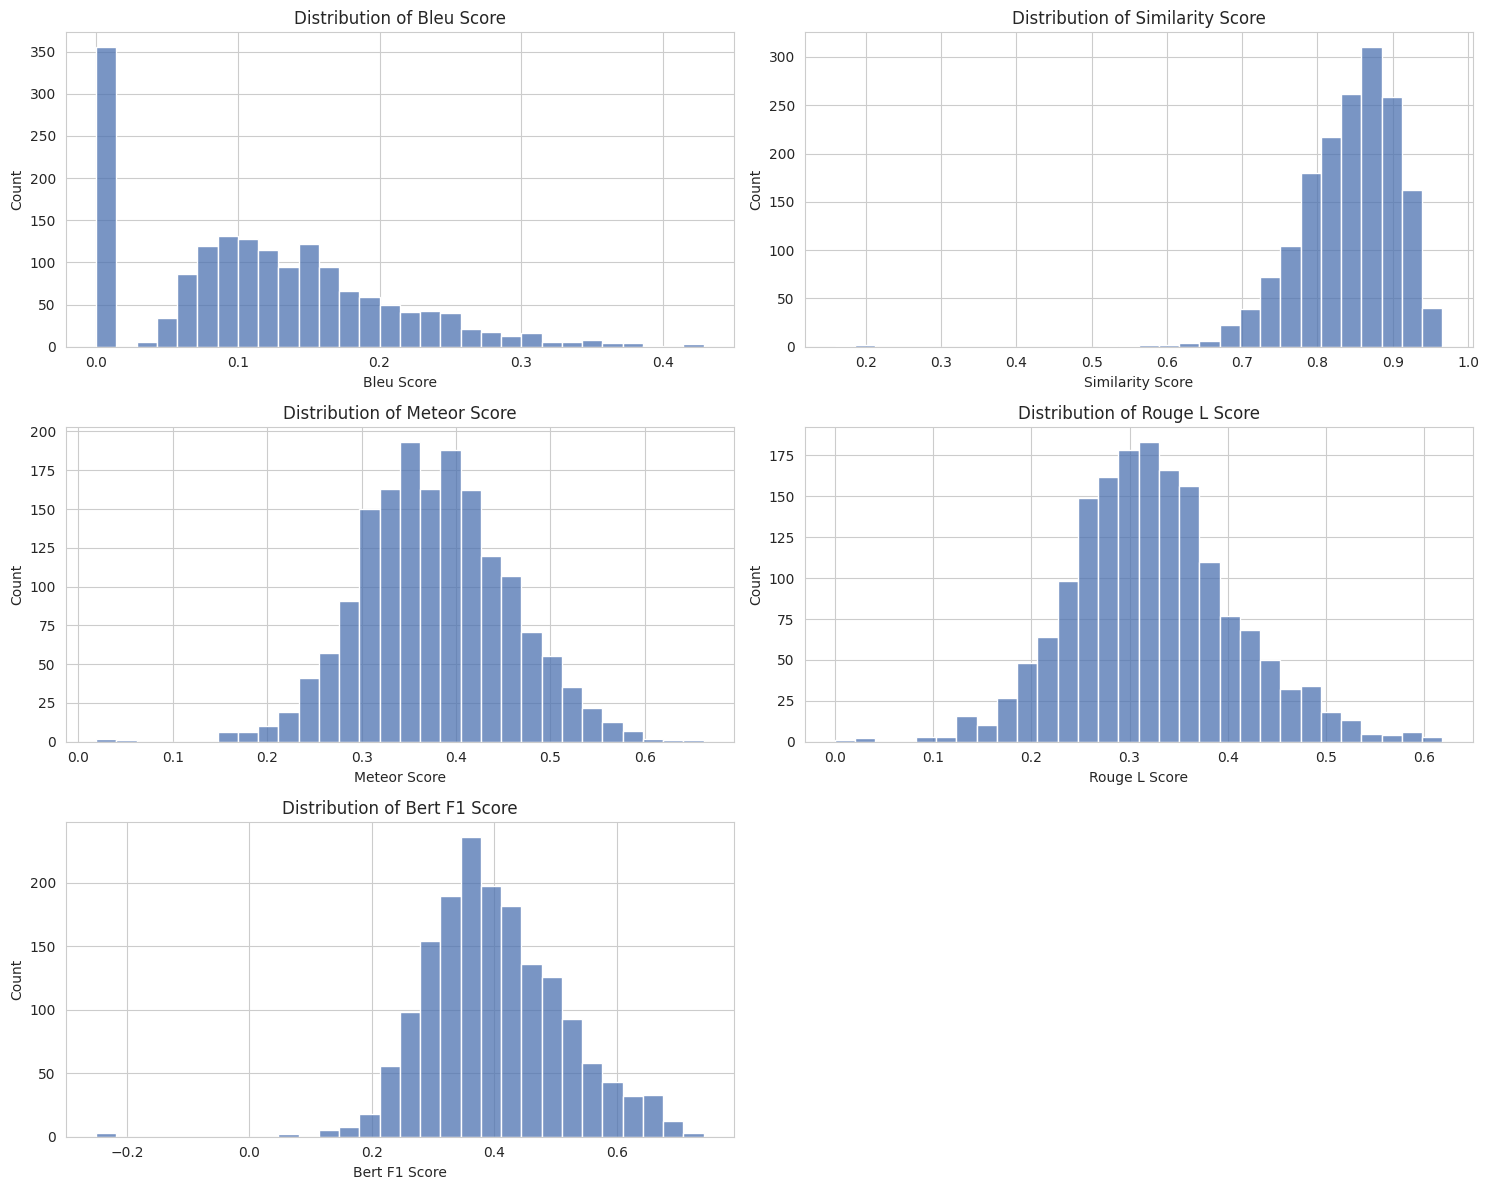

In [11]:
# Distribution of Similarity Metrics in Google Colab
# This script generates histograms to show the distribution of each similarity metric.

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (15, 12)

# Load the CSV file
# Note: In Google Colab, upload 'updated_file_with_all_scores.csv' using the Files tab
# on the left sidebar, or mount Google Drive and provide the path
try:
    df = pd.read_csv('updated_file_with_all_scores.csv')
except FileNotFoundError:
    print("Error: 'updated_file_with_all_scores.csv' not found.")
    print("Please upload the file to Colab:")
    print("1. Click the folder icon in the left sidebar")
    print("2. Click the upload button and select 'updated_file_with_all_scores.csv'")
    print("3. Rerun this cell")
    raise

# Extract damage level from input_text (optional, for context)
df['damage_level'] = df['input_text'].str.extract(r'Damage level: (\d)').astype(float)

# Clean data: ensure numeric columns and remove invalid rows
metric_columns = ['bleu_score', 'similarity_score', 'meteor_score', 'rouge_l_score', 'bert_f1_score']
for col in metric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=metric_columns + ['damage_level'])

# Create a 3x2 grid of subplots for the histograms
fig, axes = plt.subplots(3, 2)
axes = axes.ravel()

# Plot histograms for each metric
for idx, metric in enumerate(metric_columns):
    sns.histplot(data=df, x=metric, bins=30, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {metric.replace("_", " ").title()}')
    axes[idx].set_xlabel(metric.replace("_", " ").title())
    axes[idx].set_ylabel('Count')

# Hide the unused subplot
axes[-1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [7]:
!pip install rouge-score sentence-transformers sacrebleu

import nltk
nltk.download('punkt_tab')
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer
import sacrebleu
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define the two strings (placeholders - replace with your own text)
reference = "There are some moderate sidewalk issues ahead, with cracks that shouldn't cause you to trip but may require attention. You can continue walking forward, but be cautious as you approach these areas. If possible, consider stepping slightly to your left to avoid any potential discomfort from the cracks. Stay aware of your footing as you pass through this section."
hypothesis = "there ’ s some damage ahead on the sidewalk, and it ’ s best to walk over it slowly and cautiously. it ’ s about the size of a small step, so you might want to keep to your left to navigate around it safely. stay alert, and you ’ ll get through just fine!"

# Compute ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(reference, hypothesis)
print("ROUGE-1 F1:", rouge_scores['rouge1'].fmeasure)
print("ROUGE-2 F1:", rouge_scores['rouge2'].fmeasure)
print("ROUGE-L F1:", rouge_scores['rougeL'].fmeasure)

# Compute F1 score based on word overlap
ref_tokens = set(word_tokenize(reference.lower()))
hyp_tokens = set(word_tokenize(hypothesis.lower()))
overlapping = ref_tokens.intersection(hyp_tokens)
precision = len(overlapping) / len(hyp_tokens) if hyp_tokens else 0
recall = len(overlapping) / len(ref_tokens) if ref_tokens else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print("Word Overlap F1:", f1)

# Compute SBERT cosine similarity
model = SentenceTransformer('all-MiniLM-L6-v2')
ref_embedding = model.encode(reference)
hyp_embedding = model.encode(hypothesis)
similarity = cosine_similarity([ref_embedding], [hyp_embedding])[0][0]
print("SBERT Cosine Similarity:", similarity)

# Compute BLEU score
bleu = sacrebleu.corpus_bleu([hypothesis], [[reference]])
print("BLEU Score:", bleu.score)

# Compute Jaccard similarity (additional metric)
ref_words = set(word_tokenize(reference.lower()))
hyp_words = set(word_tokenize(hypothesis.lower()))
intersection = ref_words.intersection(hyp_words)
union = ref_words.union(hyp_words)
jaccard = len(intersection) / len(union) if union else 0
print("Jaccard Similarity:", jaccard)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


ROUGE-1 F1: 0.3063063063063063
ROUGE-2 F1: 0.05504587155963303
ROUGE-L F1: 0.23423423423423423
Word Overlap F1: 0.29166666666666663
SBERT Cosine Similarity: 0.7291992
BLEU Score: 4.992496371126165
Jaccard Similarity: 0.17073170731707318


In [2]:
!pip install git+https://github.com/google-research/bleurt.git

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-9a7fzzu5
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-9a7fzzu5
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 151.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 175.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 185.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 191.1 MB/s 

In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [8]:
import evaluate

# Define the two strings (replace with your own text)
reference = "There are some moderate sidewalk issues ahead, with cracks that shouldn't cause you to trip but may require attention. You can continue walking forward, but be cautious as you approach these areas. If possible, consider stepping slightly to your left to avoid any potential discomfort from the cracks. Stay aware of your footing as you pass through this section."
hypothesis = "there ’ s some damage ahead on the sidewalk, and it ’ s best to walk over it slowly and cautiously. it ’ s about the size of a small step, so you might want to keep to your left to navigate around it safely. stay alert, and you ’ ll get through just fine!"

# Load the BLEURT metric with a specific checkpoint
bleurt = evaluate.load('bleurt', module_type="metric", checkpoint='bleurt-base-128')

# Compute the BLEURT score
results = bleurt.compute(predictions=[hypothesis], references=[reference])

# Print the score
print("BLEURT score:", results['scores'][0])

BLEURT score: -0.3661385476589203


In [12]:

import nltk
nltk.download('wordnet')  # Required for METEOR

# Define the two strings (replace with your own text)
reference = "I see there is some damage directly ahead of you. I recommend approaching it slowly and cautiously, as it may disrupt your path. If you'd like, you can safely step slightly to your right to avoid any concerns. Keep your focus on your surroundings, and you’ll navigate this smoothly"
hypothesis = "there ’ s some damage ahead on the sidewalk, and it ’ s best to walk over it slowly and cautiously. it ’ s about the size of a small step, so you might want to keep to your left to navigate around it safely. stay alert, and you ’ ll get through just fine!"

# Compute METEOR score
meteor = evaluate.load('meteor')
meteor_results = meteor.compute(predictions=[hypothesis], references=[reference])

# Print the score
print("METEOR Score:", meteor_results['meteor'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


METEOR Score: 0.38884118596051825


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
!pip install sentence-transformers nltk
!pip install tf-keras
import nltk
nltk.download('punkt_tab')
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define the two strings (replace with your own text)
reference = "I see there is some damage directly ahead of you. I recommend approaching it slowly and cautiously, as it may disrupt your path. If you'd like, you can safely step slightly to your right to avoid any concerns. Keep your focus on your surroundings, and you’ll navigate this smoothly"
hypothesis = "there ’ s some damage ahead on the sidewalk, and it ’ s best to walk over it slowly and cautiously. it ’ s about the size of a small step, so you might want to keep to your left to navigate around it safely. stay alert, and you ’ ll get through just fine!"

# Tokenize the strings
ref_tokens = word_tokenize(reference.lower())
hyp_tokens = word_tokenize(hypothesis.lower())

# Load BERT-based model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for each token
ref_embeddings = [model.encode(token) for token in ref_tokens]
hyp_embeddings = [model.encode(token) for token in hyp_tokens]

# Compute pairwise cosine similarities
if ref_embeddings and hyp_embeddings:
    similarity_matrix = cosine_similarity(hyp_embeddings, ref_embeddings)

    # Consider a match if cosine similarity > threshold (e.g., 0.8)
    threshold = 0.8
    matches = (similarity_matrix > threshold).sum()

    # Calculate precision, recall, and F1
    precision = matches / len(hyp_tokens) if hyp_tokens else 0
    recall = matches / len(ref_tokens) if ref_tokens else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
else:
    f1 = 0.0

# Print the score
print("BERT-F1 Score:", f1)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


BERT-F1 Score: 1.1092436974789917
